### CUR


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("ratings_small.csv")[:100000] 
df.shape

(100000, 4)

In [3]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [4]:
# shuffling the data
from sklearn.utils import shuffle
df = shuffle(df)

In [5]:
df.head()

,userId,movieId,rating
68627,475,77561,3.5
61623,452,912,5.0
13852,90,800,5.0
61209,447,555,3.0
66611,468,7407,2.5


In [6]:
# train - 80% of the data.
num_rows = df.shape[0]
train, test = df.copy(deep = True), df[int(num_rows*0.8):].copy(deep = True)
train[int(num_rows*0.8):]['rating']  = train[int(num_rows*0.8):]['rating']*0
train = shuffle(train, random_state=0)

In [7]:
# creating user-movie rating utility matrix
user_movie_rating =train.groupby(['userId','movieId'])['rating'].max().unstack().fillna(0)
user_movie_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def low_rank_k(rank, u, s, v):
    # SVD 
    u_new = u[:,:rank]
    v_new = v[:rank, :]
    s_new = s[:rank]
    singular_mat = np.diag(s_new)
    low_rank_mat = np.dot(np.dot(u_new, singular_mat), v_new)
    return low_rank_mat

In [9]:
def error(y_hat, y):
    # MSE
    y_hat = np.array(y_hat)
    y = np.array(y)
    MSE_ = (y_hat- y)**2
    MSE = MSE_.sum()/len(y_hat)
    return MSE

In [10]:
relevance_threshold = 1
relevant_df = df.loc[(df['rating'] >= relevance_threshold)]

In [11]:
print("Number of relevant user item pair is {} out of {}".format(len(relevant_df), len(df)))

Number of relevant user item pair is 98899 out of 100000


In [12]:
u, s, v = np.linalg.svd(user_movie_rating, full_matrices=False)
optimal_k=10
Pred = low_rank_k(optimal_k, u, s, v)
Pred = pd.DataFrame(Pred, columns=user_movie_rating.columns, index= user_movie_rating.index)
y_hat = [Pred.loc[int(test.iloc[i]['userId']), int(test.iloc[i]['movieId'])] 
             for i in range(len(test))] 

In [13]:
def cur(A, k):
  
  A = A.to_numpy()
  # print(A.shape)

  if (k > A.shape[0]) or (k > A.shape[1]):
    print("error: k greater than matrix dimensions.\n")
    return

  R = np.zeros(( k, A.shape[1]))
  C = np.zeros((A.shape[0], k))  
  W = np.zeros((k, k))

  A_square = A**2
  A_sum_square = np.sum(A_square)
    
  #Prob of each row
  prob_row = np.sum(A_square, axis = 1) / A_sum_square
  #Prob of each col
  prob_col =  np.sum(A_square, axis = 0) / A_sum_square
  


  #selecting rows
  r_count = 0
  row_taken_list = []
  row_dup_list = []

  while r_count < k:
    i = np.random.choice(np.arange(A.shape[0]), p = prob_row)
    #if row already taken, increase the count of duplicates
    if i in row_taken_list:
      row_dup_list[row_taken_list.index(i)] =  row_dup_list[row_taken_list.index(i)] + 1      
    
    #if row not taken, divide it with root of (k*prob of row) and take it
    elif i not in row_taken_list:
      R[r_count, :] = A[i, :] / np.sqrt(prob_row[i]*k)
      r_count = r_count + 1
      row_taken_list.append(i)
      row_dup_list.append(1)
        
  
  #multiplying rows by root of no. of duplicates
  R = np.multiply(R.T, np.sqrt(row_dup_list))
  R = R.T


  #selecting columns
  c_count = 0
  col_taken_list = []
  col_dup_list = []

  while c_count < k:
    i = np.random.choice(np.arange(A.shape[1]), p = prob_col)
    #if column already taken, increase the count of duplicates
    if i in col_taken_list:
      col_dup_list[col_taken_list.index(i)] =  col_dup_list[col_taken_list.index(i)] + 1      
    
    #if column not taken, divide it with root of (k*prob of column) and take it
    elif i not in col_taken_list:
      C[:, c_count] = A[:, i] / np.sqrt(prob_col[i]*k)
      c_count = c_count + 1
      col_taken_list.append(i)
      col_dup_list.append(1)
  
  #multiplying columns by root of no. of duplicates
  C = np.multiply(C, np.sqrt(col_dup_list))

  #intersection matrix W
  for i, I in enumerate(row_taken_list):
    for j, J in enumerate(col_taken_list):
      W[i, j] = A[I, J]

  #Calculating svd decomposition of W
  X, sigma, Y_T = np.linalg.svd(W, full_matrices=False)
  sigma = np.diag(sigma)

  #Taking pseudo-inverse of sigma
  for i in range(k):
    if sigma[i, i] >= 1:
      sigma[i, i] = 1/sigma[i, i]
    else:
      sigma[i, i] = 0

  #Calculating U
  U = np.dot(Y_T.T, np.dot(np.dot(sigma, sigma), X.T))

  return C, U, R

In [14]:
#Looping N times to select the min value of CUR for a particular k 
#Done to select C, U, R corresponding to the decomposition with min error 
def CUR_best(A, k, N = 10):
  c, u, r  = cur(A, k)
  err = error(A, c@u@r)
  for i in range(N):
    ctmp, utmp, rtmp  = cur(A, k)
    err_temp = error(A, ctmp@utmp@rtmp)
    Pred_my_new = np.dot(np.dot(ctmp, utmp), rtmp)
    Pred_my_new = pd.DataFrame(Pred_my_new, columns=A.columns, index= A.index)
    y_hat = [Pred_my_new.loc[int(test.iloc[i]['userId']), int(test.iloc[i]['movieId'])] 
                  for i in range(len(test))] 
    err_temp = error(y_hat, test['rating'])
    if err_temp < err:
      err = err_temp
      c = ctmp
      u = utmp
      r = rtmp
  return c, u, r, err

errors= [] 
def cur_loop(A):
    errors_my_new_1 = []
    ks = np.arange(1, 650, 20)
    for k in ks:
      c,u,r, err = CUR_best(A, k)
      errors_my_new_1.append(err)
    return errors_my_new_1
    
errors = cur_loop(user_movie_rating)

<Figure size 432x288 with 0 Axes>

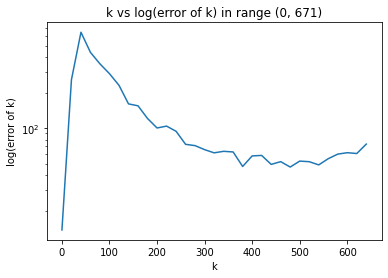

<Figure size 432x288 with 0 Axes>

In [15]:
#plotting errors_pip
plt.yscale("log")
plt.plot(np.arange(0, 660, 20), errors)
plt.xlabel('k')
plt.ylabel('log(error of k)')
plt.title('k vs log(error of k) in range (0, 671)')
plt.figure()

In [34]:
np.arange(0, 660, 20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500,
       520, 540, 560, 580, 600, 620, 640])

In [16]:
errors

[13.742125,
 256.8024089784333,
 647.5038170727106,
 436.950751931859,
 349.39596813010706,
 288.61431312331285,
 230.07734940388966,
 160.2207092096026,
 154.3536590792949,
 120.55660151994387,
 100.1945034429731,
 103.92618492389569,
 93.97201014974796,
 72.85692288928112,
 71.02677125514806,
 65.68553621316289,
 61.72764572138842,
 63.58086729097915,
 62.796719167306996,
 47.3217249884774,
 58.14391626908556,
 58.6876662260369,
 49.27304218587773,
 51.985775947243305,
 46.79684916838867,
 52.54889024642751,
 51.94601735562526,
 48.805665334946404,
 55.08104316983966,
 60.21967086357797,
 61.89825624332248,
 60.901661148657105,
 73.22737418379113]

In [35]:
  #Time taken for single CUR decomposition corresponding to the best k 
  %%time
  A = user_movie_rating
  k  = 480
  y_hat = []
  c, u, r  = cur(A, k)
  err = error(A, c@u@r)
  for i in range(0, 1):
    ctmp, utmp, rtmp  = cur(A, k)
    err_temp = error(A, ctmp@utmp@rtmp)
    Pred_my_new = np.dot(np.dot(ctmp, utmp), rtmp)
    Pred_my_new = pd.DataFrame(Pred_my_new, columns=A.columns, index= A.index)
    y_hat_i = [Pred_my_new.loc[int(test.iloc[i]['userId']), int(test.iloc[i]['movieId'])] 
                  for i in range(len(test))] 
    err_temp = error(y_hat_i, test['rating'])
    if err_temp < err:
      err = err_temp
      c = ctmp
      u = utmp
      r = rtmp
      y_hat = y_hat_i

CPU times: user 7.97 s, sys: 512 ms, total: 8.48 s
Wall time: 7.62 s


In [36]:
test['prediction'] = y_hat
test.head()

,userId,movieId,rating,prediction
86626,580,899,4.0,8.440072
87195,580,7766,4.0,4.608307
73762,514,1252,4.0,0.523224
73166,509,7156,3.5,4.205320
46070,333,356,4.5,-2.762270


In [37]:
from collections import Counter
user_freq_dict = Counter(test['userId'].tolist())
max_voting = max(user_freq_dict.values())
for i in user_freq_dict:
    if user_freq_dict[i] == max_voting:
        user_choice =i

In [38]:
one_user= test.loc[(test['userId'] == 17)].sort_values('rating', 
                      inplace=False, 
                      ascending=False)
one_user.head()

,userId,movieId,rating,prediction
3045,17,31410,5.0,-4.529378
2908,17,4848,5.0,0.679043
2712,17,318,5.0,4.269132
2996,17,7123,5.0,1.098429
2840,17,2551,5.0,1.227672


### Recall and Precision

In [39]:
relevance_threshold = 2
recommended_movies = set(one_user.loc[(one_user['prediction'] >= relevance_threshold)]['movieId'].tolist())
relavent_movies = set(one_user.loc[(one_user['rating'] >= relevance_threshold)]['movieId'].tolist())
len(relavent_movies), len(recommended_movies)

(80, 21)

In [40]:
recommended_movies_intersection_relavant_movies = [i for i in recommended_movies if i in relavent_movies]
recommended_movies_intersection_relavant_movies;

In [41]:
len(recommended_movies), len(recommended_movies_intersection_relavant_movies), len(relavent_movies)

(21, 20, 80)

In [42]:
recall = len(recommended_movies_intersection_relavant_movies)/len(relavent_movies)
precision = len(recommended_movies_intersection_relavant_movies)/len(recommended_movies)

In [43]:
precision, recall

(0.9523809523809523, 0.25)

In [44]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.39603960396039606

### Recall@k and Precision@k
- recall and precision on top k predictions

In [45]:
k=18
top_k_predictions_df = one_user.sort_values('prediction', ascending=False)[:k]
top_k_predictions_df.head()

,userId,movieId,rating,prediction
2695,17,36,4.5,18.617867
2701,17,185,3.0,16.341101
2857,17,2858,4.5,12.675472
2868,17,3160,2.5,11.870240
2883,17,3730,3.0,10.417786


In [46]:
relevance_threshold=2
top_k_movies_recommended = set(top_k_predictions_df.loc[(top_k_predictions_df['prediction'] >= relevance_threshold)]['movieId'].tolist())
top_k_movies_relevant = set(top_k_predictions_df.loc[(top_k_predictions_df['rating'] >= relevance_threshold)]['movieId'].tolist())

In [47]:
recommended_movies_intersection_relavant_movies = [i for i in top_k_movies_recommended
                                                   if i in top_k_movies_relevant]
recommended_movies_intersection_relavant_movies

[318,
 866,
 1411,
 36,
 965,
 6502,
 1255,
 1464,
 2858,
 6987,
 5105,
 3730,
 8914,
 3160,
 185,
 1244,
 25]

In [48]:
len(top_k_movies_recommended), len(recommended_movies_intersection_relavant_movies), len(top_k_movies_relevant)

(18, 17, 17)

In [49]:
if len(top_k_movies_relevant)!=0:
    recall = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_relevant)
else:
    recall = 1
if len(top_k_movies_recommended)!=0:
    precision = len(recommended_movies_intersection_relavant_movies)/len(top_k_movies_recommended)
else:
    precision = 1

In [50]:
precision, recall

(0.9444444444444444, 1.0)

In [51]:
f_score = 2*precision*recall/(precision+recall)
f_score

0.9714285714285714